# Tensorflow CNN on photos - detect clouds, rather than fog
Author: Autumn Nguyen

Independent study Fall 2023 🌟💭

Mentored by Professor Alyx Burns

Mount Holyoke College

---

This notebook has the code I wrote to implement a Convolutional Neural Network (CNN) in Tensorflow to classify fog photos. It also has my explanations of the concepts I learned throughout the process.

The fog photos were taken by the field cameras that Professor Jessica Lundquist, Dr. Steven Pestana (@University of Washington) and I set up on San Juan Island in the summer of 2023, for the purpose of our coastal fog research. I wanted to learn how to efficiently acquire data from these camera photos without having to manually look through the photos to see at what time there had been fog. Aside from my own learning purpose, I hope the CNN I trained can be helpful in supporting coastal fog research 🌫🌊!

All of the following parts, until finished training the model, should be done in Google **Colab**, using T4 GPU.

## Import libraries and specify path to data

In [2]:
import tensorflow as tf
import os

import numpy as np
from matplotlib import pyplot as plt

I ran this notebook during T4 GPU, rather than the default CPU, in the runtime type of Colab.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Path to directory with image files
PATH = "/content/drive/MyDrive/Fog\ FHL\ REU\ 2023/cattlepoint_cloud_and_nocloud.zip"
!unzip -n -d data $PATH > /dev/null
# If encounter error cannot find file (even when use the correct path with "\" and no typo):
# just disconnect runtime and start again

In [5]:
import shutil
shutil.rmtree('data/__MACOSX')

## Input pipeline

I used a Keras utility, ```image_dataset_from_directory()```, to read in and pre-process the data. This utility generates a ```tf.data.Dataset```, from image files in the directory we set the path for above. This Dataset allows us to **apply pre-processing** steps (like normalizing pixel values, resizing images, etc.) to the dataset **batch by batch**.

In simple words, if your dataset has 320 files, this utility will automatically **divide the dataset into 10  batches** of 32 files each, and when you tell it, for example, "give me 70% of all the data you have so that I can train the model", it will **take 32 files, apply the pre-processing steps to those files, give you that batch, then repeat** this 7 times to eventually give you 7 processed batches of images.

Creating the input pipeline this way is essential to this project. I initially loaded all the data into one variable and called the functions to resize and rescale the images on that variable, and Google Colab (the free version) ran out of RAM, crashed, and asked me to upgrade to Colab Pro. Even though I only have 73 image files, each file is originally 2592x1944 pixels, which sums up to **too much memory for Google Colab to have on RAM at one time**. ```image_dataset_from_directory()``` helps us not need to have all the images on RAM at once -- everytime we need some, it will get a bit of data and pass them through the input pileline, which requires much less RAM.




In [6]:
data = tf.keras.utils.image_dataset_from_directory('data',
                                                   class_names = ["no_cloud", "cloud"],
                                                   batch_size=10,
                                                   image_size=(256,256),
                                                   shuffle=True)

Found 100 files belonging to 2 classes.


In [7]:
''' Add scaling to the data pipeline: scaling the range of each pixel from 0-255 to 0-1 '''
scaled_data = data.map(lambda x,y: (x/255, y))

### Visualize data in a batch

In [8]:
data_iterator = scaled_data.as_numpy_iterator()

In [9]:
# try getting one batch
batch = data_iterator.next()

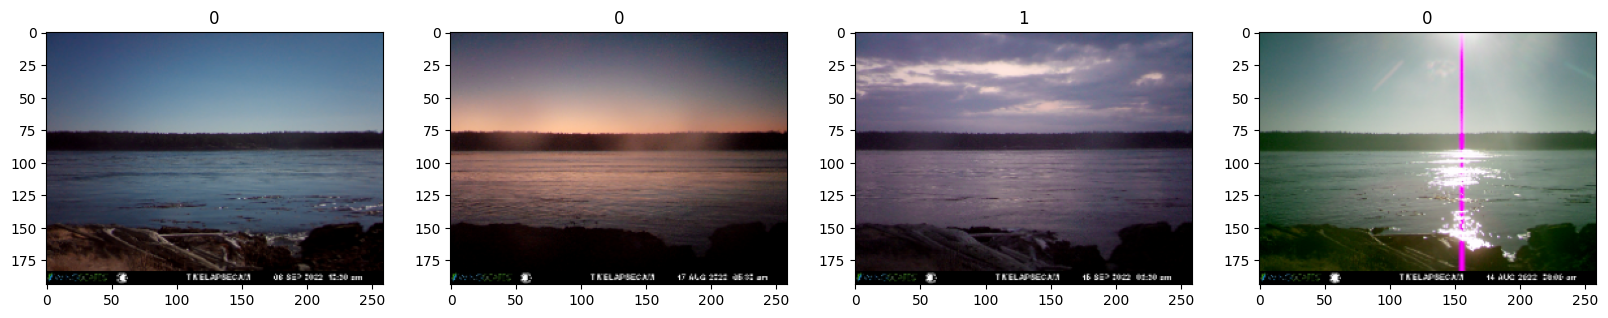

In [10]:
# visualize the first 4 photos in the generated batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(tf.image.resize(img, (1944//10, 2592//10)).numpy()) # If not scaled from 0-255 to 0-1 yet, use .imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Class 0 is images with no cloud, class 1 is with cloud.

## Partition data into train/val/test set

In [11]:
''' Specify the size of the train/validation/test sets'''

train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)
test_size = len(scaled_data) - train_size - val_size

# Make sure train_size, val_size, and test_size sums up to the total number of batches from the whole dataset
print(train_size, val_size, test_size, len(scaled_data))

7 2 1 10


In [12]:
''' Partition train/val/test '''

# Should make sure the data has already been shuffled (I've done it in image_dataset_from_directory())

train = scaled_data.take(train_size)                          # Take the number of train batches among the total number of batches to be the training set
val = scaled_data.skip(train_size).take(val_size)             # Skip the first number of batches (that have already been in the training set) and take the next batches for validation set.
test = scaled_data.skip(train_size+val_size).take(test_size)  # Skip the batches already taken for train & validation, and take the next batches for the test set.

### Save data in variables (don't run)
This is the old code I used to experiment with saving data from the batches.

In [13]:
# train_batches = train.as_numpy_iterator()
# val_batches = val.as_numpy_iterator()
# test_batches = test.as_numpy_iterator()

# # Store data generated from these batches in variables
# # to be able to re-run some functions on them later
# # as we cannot get the same batches again after we've depleted data in the data iterator

# X_train = []
# y_train = []
# X_val = []
# y_val = []
# X_test = []
# y_test = []

In [14]:
# # took a long time (~30 secs) just to run: for batch in [1 batch]: X,y = batch
# # 2 mins to run when batch_size = 32

# for batch in train_batches:
#   X_i,y_i = batch
#   X_train.append(X_i)
#   y_train.append(y_i)

# for batch in val_batches:
#   X_i,y_i = batch
#   X_val.append(X_i)
#   y_val.append(y_i)

# for batch in test_batches:
#   X_i,y_i = batch # these are NumPy arrays. X_i.shape = (32, 400, 600, 3); y_i.shape = (32,0)
#   X_test.extend(X_i)
#   y_test.extend(y_i)

In [15]:
# X_train = np.array(X_train)
# print(X_train.shape)
# y_train = np.array(y_train)
# print(y_train.shape)

In [16]:
# X_train_reshaped = X_train.reshape(8*32, 400, 600, 3)
# print(X_train_reshaped.shape)

In [17]:
# y_train_reshaped = y_train.reshape(8*32)
# print(y_train_reshaped.shape)

## Model with Convolutional and Pooling layers

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [19]:
# Design the model architecture
cnn_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (5,5), activation='relu',
                         kernel_initializer='he_normal',
                         input_shape=(256, 256, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile the model
cnn_1.compile(optimizer = 'adam',
              loss = tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [21]:
# Create a log directory to keep log of the model performance during training, which we can visualize afterwards
logdir='logs'

In [22]:
# Define a ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_cloud_nocloud.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the model with the best validation accuracy
    verbose=1                  # Print information when saving the model
)

# Include the ModelCheckpoint in the list of callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Adjust the fit function to include the checkpoint callback
hist = cnn_1.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[tensorboard_callback, checkpoint_callback]  # Add checkpoint callback here
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5874 - loss: 0.6313
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to best_model_cloud_nocloud.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 606ms/step - accuracy: 0.5890 - loss: 0.6372 - val_accuracy: 0.8500 - val_loss: 0.4127
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8031 - loss: 0.4722
Epoch 2: val_accuracy did not improve from 0.85000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 681ms/step - accuracy: 0.7991 - loss: 0.4818 - val_accuracy: 0.8500 - val_loss: 0.2849
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7771 - loss: 0.4268
Epoch 3: val_accuracy improved from 0.85000 to 0.95000, saving model to best_model_cloud_nocloud.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 806ms/step - accuracy: 0.7764 - loss: 0.4281 - val_accuracy: 0.9500 - val_loss: 0.2812
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9135 - loss: 0.1972
Epoch 4: val_accuracy did not improve from 0.95000
7/7 ━━━━━━━━━━

In [23]:
cnn_1.summary() # need to specify input shape when creating the first Conv2D layer

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 252, 252, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         123,009 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 386,597 (1.47 MB)

 Trainable params: 128,865 (503.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 257,732 (1006.77 KB)

Remember to download the .keras file of the best model (and upload to your Drive if you want) because otherwise, it would just be saved on Google Colab, not your Drive, and would be lost after the Colab session was disconnected.

## Plot performance

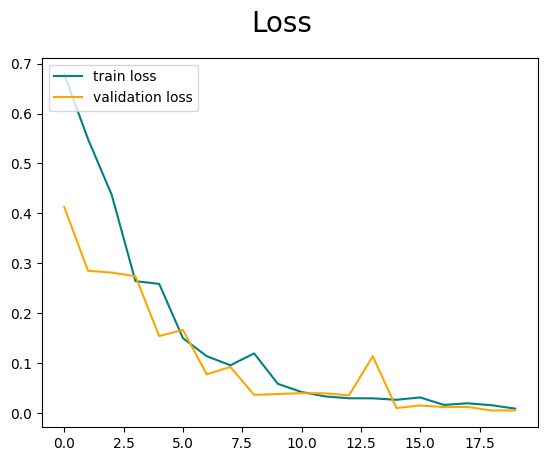

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train loss')
plt.plot(hist.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

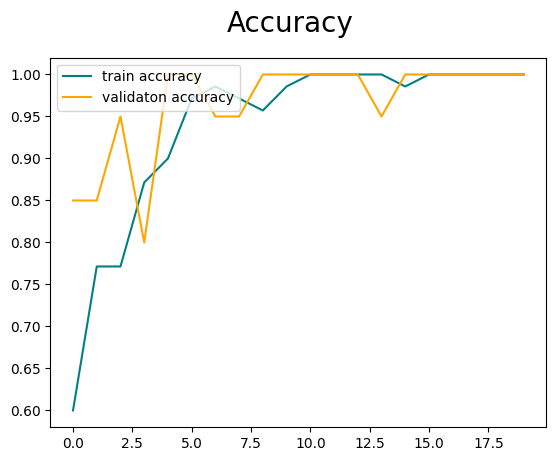

In [25]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='train accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='validaton accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluation

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()       # What proportion of fog predictions was actually real fog? (TP/ TP + FP)
re = Recall()           # What proportion of actual fog was corrected identified? (TP / TP + FN)
acc = BinaryAccuracy()  # Just accuracy for binary classificatrion (?)

In [27]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = cnn_1.predict(X)

    predicted = []
    predicted = yhat>0.5
    print("True labels: ", y)
    print("Predicted labels: ", predicted.flatten())

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
True labels:  [0 0 0 1 1 0 0 1 1 0]
Predicted labels:  [False False False  True  True False False  True  True False]
1.0 1.0 1.0


#### If testing on stored variables (don't run)

In [28]:
# For stored variables (don't run)
# for i in range(len(X_test)):
#     yhat = model.predict(X_test[i])

#     predicted = []
#     predicted = yhat>0.5
#     print("True labels: ", y_test[i])
#     print("Predicted labels: ", predicted.flatten())

#     pre.update_state(y_test[i], yhat)
#     re.update_state(y_test[i], yhat)
#     acc.update_state(y_test[i], yhat)

# print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

## Test

In [29]:
import cv2
def test_img(image_name:str):
  img = cv2.imread(image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(tf.image.resize(img, (256,384)).numpy().astype(int))
  plt.show()

  resize = tf.image.resize(img, (256,256))
  yhat = cnn_1.predict(np.expand_dims(resize/255, 0))
  print(yhat)
  if yhat > 0.5:
      print(f'Predicted: Cloud')
  else:
      print(f'Predicted: No Cloud')


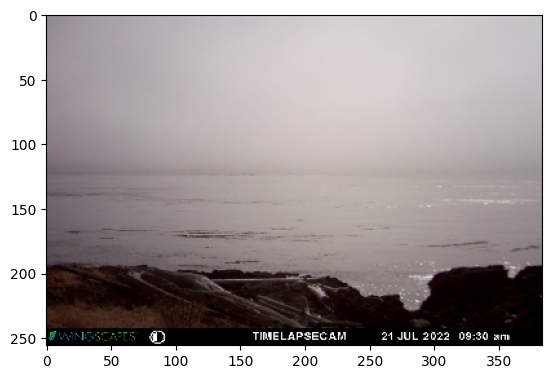

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
[[0.9999417]]
Predicted: Cloud


In [30]:
test_img("/content/data/cloud/WSCT7354.JPG")


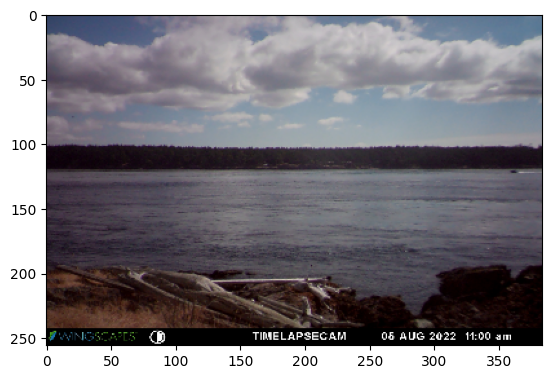

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.99721473]]
Predicted: Cloud


In [31]:
test_img("/content/data/cloud/WSCT7837.JPG")

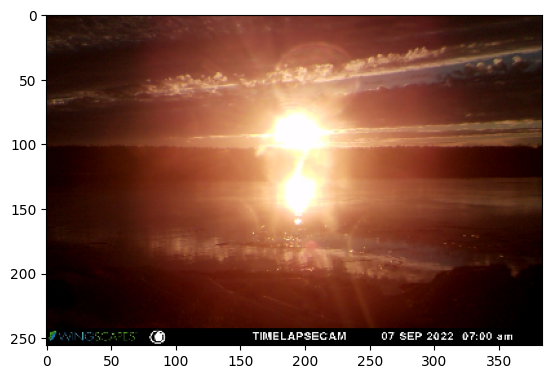

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.99904054]]
Predicted: Cloud


In [32]:
test_img("/content/data/cloud/WSCT8885.JPG")

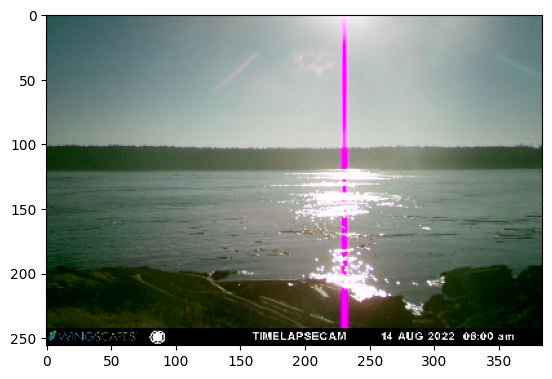

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[8.422254e-05]]
Predicted: No Cloud


In [33]:
test_img("/content/data/no_cloud/WSCT8119.JPG")

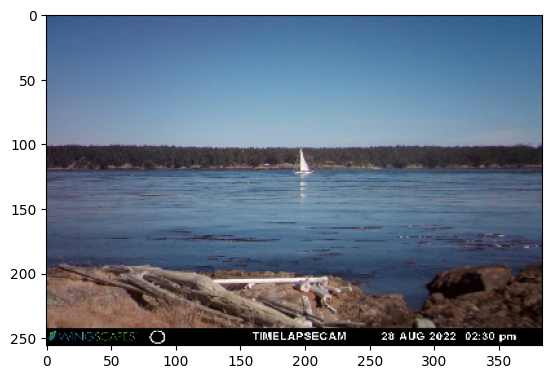

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.00070208]]
Predicted: No Cloud


In [34]:
test_img("/content/data/no_cloud/WSCT8580.JPG")

## Load the best model to do inferences

In [ ]:
import os
import shutil
import zipfile
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from datetime import datetime
import pytz
from google.colab import files

# Step 1: Upload ZIP file to Colab
# uploaded = files.upload()

# Define the directory where the images will be extracted
image_folder = '/content/inference_images'

# If the folder already exists, delete it before extracting new images
if os.path.exists(image_folder):
    shutil.rmtree(image_folder)  # Remove the directory and its contents

# Step 2: Extract the uploaded ZIP file
zip_file_name = '/content/drive/MyDrive/Fog FHL REU 2023/cattlepoint_all_photos.zip'  # Get the uploaded file name
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(image_folder)  # Extract to a folder in Colab

image_folder = '/content/inference_images/photos' # because my zip file contains a subfolder that holds the photos, redefine the path to point to that subfolder

# Step 3: Load the best model saved in .keras format
model = load_model('/content/drive/MyDrive/Fog FHL REU 2023/best_model_cloud_nocloud.keras')

In [ ]:
# Initialize an empty list to store results
results = []

# Iterate over all images in the extracted folder
for img_file in os.listdir(image_folder):
    # Ensure the file is an image
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Construct the full path to the image
        img_path = os.path.join(image_folder, img_file)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(256, 256))  # Adjust size as per your model input size
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize the image
        img_array = img_array.reshape(1, 256, 256, 3)  # Adjust shape as per model input

        # Predict
        prediction = model.predict(img_array)
        predicted_label = 'cloud' if prediction[0][0] > 0.5 else 'no_cloud'

        # Extract datetime metadata from the image (if available)
        try:
            img_pil = Image.open(img_path)
            exif_data = img_pil._getexif()
            datetime_taken = exif_data.get(36867)  # Tag 36867 is the datetime in EXIF
            # Convert the datetime string to a Python datetime object
            datetime_taken = datetime.strptime(datetime_taken, '%Y:%m:%d %H:%M:%S')
            # # Set the timezone for datetime as needed (e.g., Pacific Time)
            # datetime_taken = pytz.timezone('US/Pacific').localize(datetime_taken)
        except:
            # If no metadata is found, set datetime to None
            datetime_taken = None

        # Append the results (filename, datetime, predicted label) to the list
        results.append([img_file, datetime_taken, predicted_label])

# Step 4: Convert results to a pandas DataFrame and save it as a CSV file
results_df = pd.DataFrame(results, columns=['Image File', 'Time', 'Predicted Label'])

# Sort the DataFrame alphabetically by the 'Image File Name' column
results_df = results_df.sort_values(by='Time')

# Save the results to a CSV file
results_df.to_csv('inference_results.csv', index=False)

# Download the CSV file to your local system
files.download('inference_results.csv')

# Display a sample of the results
results_df.head()
